# Deep Learning
This notebook is to handele the prediction part for new images

In [1]:
%matplotlib inline

import cPickle as pickle
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import cv2
import json
from scipy import ndimage

#### Hyperparameter

In [2]:
copy_image_file = "final_letters_result.jpeg"
green_rectangle_positions = "letters_rectangle_shapes.json"
final_result = "final_digitized_image.jpg"
basket = "/mnt/basket/processingData/volatile/notMNIST"
dictionary_processing_files = "/mnt/basket/processingData/volatile/pro-img/"
pickle_training_results_filename = "2_fullyconnected_separeated__training_results.pickle"
image_size = 28

First reload the data we generated in `02_Training.ipynb`.

In [3]:
pickle_file = os.path.join(basket,pickle_training_results_filename)

with open(pickle_file, 'rb') as f:
  read = pickle.load(f)
  train_weights_hidden = read['weights_hidden_1']
  train_biases_hidden = read['biases_hidden_1']
  train_weights_linear = read['weights_linear']
  train_biases_linear = read['biases_linear']
  del read  # hint to help gc free up memory

#### Further adjust cropped image to the MNIST requirements

To calculate predictions it is needed to flatten the cropped images. <br>
Additional the MNIST images are in the range from 0-1 and not from 0-255 <br>
Therefore: 
 * reshape the cropped image data to a one dimensional vector with 784 pixels (28 row x 28 column = 784)
 * divide each pixel by max RGB value (255.0), to flatten the pixels to values between 0-1

In [4]:
def load_data(allImages=True,singleInputFilename=""):
    test_dataset=[]
    image_fileNames=[]

    if(allImages is True):
        # get all cropped image filenames by scaning the directory where we did store them
        for filenames in os.listdir(dictionary_processing_files):
            if (filenames.endswith(".png")):
                image_fileNames.append(filenames)

        # create an array where we can store all the digits found in step "01_NormalizeImage.ipynb"
        test_dataset = np.zeros((len(image_fileNames),784))

        # flatten the images and store them in an array
        i=0
        for input_file in image_fileNames:
            gray = (ndimage.imread(dictionary_processing_files+input_file).astype(float) - 255.0 / 2) / 255.0
            test_dataset[i] = reformat(gray)
            i = i + 1
    else:
        # Load single image
        test_dataset = np.zeros((1,784))

        gray = (ndimage.imread(singleInputFilename).astype(float) - 255.0 / 2) / 255.0
        test_dataset[0] = reformat(gray)



    print "test_datset_shape : " , test_dataset.shape
    return test_dataset, image_fileNames

Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [5]:
def reformat(dataset):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  return dataset

### Utility function

In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [7]:
def plotSingleImage(image_location,figsize_x=2.0, figsize_y=5.0, cmap="gray",):
    plt.rcParams["figure.figsize"] = {figsize_x,figsize_y}
    image_data = (ndimage.imread(image_location))
    plt.imshow(image_data, cmap=cmap)
    plt.show()

## Define the graph

In [8]:
batch_size = 128
learning_rate = 0.5
graph = tf.Graph()

## A placeholder for our image data: None stands for an unspecified number of images 784 = 28*28 pixel
tf_test_dataset = tf.placeholder("float", [None, 784])

    
#Define HyperParameters (NN structuring constants)
inputLayerSize = image_size * image_size # inputLayerSize is always equal to width of X-ndarray (200000,784)
    
# Variables:
weights_hidden_1 = tf.constant(train_weights_hidden) #(784,1024)
biases_hidden_1 = tf.constant(train_biases_hidden) #(1024)
## linear layer
weights_linear = tf.constant(train_weights_linear) #(1024,10)
biases_linear = tf.constant(train_biases_linear) #(10)


# Hidden layer (RELU)
test_hiddenLayer = tf.nn.relu(tf.matmul(tf_test_dataset, weights_hidden_1) + biases_hidden_1) #(128,1024)

# linear layer
test_logits = tf.matmul(test_hiddenLayer, weights_linear) + biases_linear  # tune w2,h2

 
# Predictions for the training, validation, and test data.
test_prediction = tf.nn.softmax(test_logits)

## Digression: Predict the fourth cropped image
Load cropped image directly from harddisk

In [39]:
singleInputFilename = "/mnt/basket/processingData/volatile/pro-img/cropped_diget_595_1320.png"   # E
test_dataset, image_fileNames = load_data(False,singleInputFilename)

test_datset_shape :  (1, 784)


Show the image

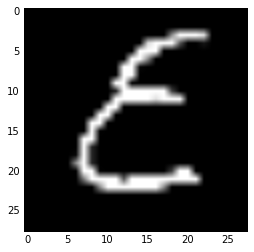

In [40]:
image_data = (ndimage.imread(singleInputFilename))
figure_size= plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = {4.0,6.0}
plt.imshow(image_data, cmap="gray")
plt.show()

Launch the graph in a session and initialize variables

In [41]:
sess = tf.Session()
tf.initialize_all_variables().run(session=sess)

calculate the reliability that the digit from this image belongs to  0,1,2,3,4,5,6,7,8,9

In [42]:
i = 0
prediction = test_prediction
predicted_results = sess.run(prediction, feed_dict={tf_test_dataset: test_dataset})
for reliability in predicted_results[0].tolist():
    print chr(i + ord('A')) , " : (" , np.round(reliability,4) , ")" 
    i = i + 1

A  : ( 0.1307 )
B  : ( 0.0251 )
C  : ( 0.2627 )
D  : ( 0.0008 )
E  : ( 0.5123 )
F  : ( 0.0001 )
G  : ( 0.019 )
H  : ( 0.0001 )
I  : ( 0.0492 )
J  : ( 0.0002 )


the sum of the reliability must always be "1.0" to represent "100 %"

In [43]:
print np.sum(predicted_results) , "    or    "  , \
    np.round(np.sum(predicted_results) * 100.0, 4) , "% "

1.0     or     100.0 % 


find the reliability with the highest value out of digit range [ 0,1,2,3,4,5,6,7,8,9 ]

In [44]:
reliability_max = tf.reduce_max(test_prediction,reduction_indices=1)
predicted_reliability = sess.run(reliability_max, feed_dict={tf_test_dataset: test_dataset})
print predicted_reliability[0]

0.512259


show the digit as a number refered to by the reliability_max

In [45]:
prediction = tf.argmax(test_prediction,1)
predicted_results = sess.run(prediction, feed_dict={tf_test_dataset: test_dataset})
print  chr(predicted_results  + ord('A'))

E


close the session

In [16]:
sess.close()

## Predict all the letters in the original image


Launch the graph in a session and initialize variables


In [17]:
sess = tf.Session()
tf.initialize_all_variables().run(session=sess)

Load all images

In [18]:
test_dataset , image_fileNames = load_data(allImages=True)
#test_dataset = reformat(test_dataset)

test_datset_shape :  (51, 784)


The prediction will contain the digit as a number in [1] and the reliability for this number in [0]

In [19]:
prediction = [tf.reduce_max(test_prediction,reduction_indices=1),tf.argmax(test_prediction,1)]
predicted_results = sess.run(prediction, feed_dict={tf_test_dataset: test_dataset}) 

for i in range(len(predicted_results[0])):
    print "predicted letter:  %s   | reliability_max: %4f   |   %s"  % \
       ( chr(predicted_results[1][i] + ord('A')) , predicted_results[0][i] , image_fileNames[i])

predicted letter:  A   | reliability_max: 0.894531   |   cropped_diget_350_100.png
predicted letter:  A   | reliability_max: 0.619830   |   cropped_diget_660_100.png
predicted letter:  C   | reliability_max: 0.999820   |   cropped_diget_960_665.png
predicted letter:  A   | reliability_max: 0.448625   |   cropped_diget_625_475.png
predicted letter:  D   | reliability_max: 0.635040   |   cropped_diget_390_3000.png
predicted letter:  B   | reliability_max: 0.596640   |   cropped_diget_75_440.png
predicted letter:  G   | reliability_max: 0.421745   |   cropped_diget_1350_400.png
predicted letter:  E   | reliability_max: 0.999984   |   cropped_diget_1300_1290.png
predicted letter:  C   | reliability_max: 0.691972   |   cropped_diget_35_2050.png
predicted letter:  F   | reliability_max: 0.787349   |   cropped_diget_35_1350.png
predicted letter:  D   | reliability_max: 0.750779   |   cropped_diget_1275_950.png
predicted letter:  G   | reliability_max: 0.306839   |   cropped_diget_0_2385.png
p

close the session

In [20]:
sess.close()

## Postprocessing
Draw a green rectangle around each digit in the original image which contains at its edges the predicted number 
of the digit and the maximum reliability for this prediction

##### Postprocessing: link predictions to saved png files

In [21]:
combined_images_with_predicted_results = dict()
i = 0
for file in image_fileNames:
    combined_images_with_predicted_results[dictionary_processing_files + file] = [predicted_results[0][i],predicted_results[1][i]]
    #combined_images_with_predicted_results.append([image_fileNames[i],predicted_results[i]])
    i = i +1
#print combined_images_with_predicted_results[dictionary_processing_files + 'cropped_diget_700_950.png'][1]

#### Postprocessing : Draw green rectangle

Read rectangle shapes from 01_NormalizeImage

In [22]:
with open(dictionary_processing_files + green_rectangle_positions) as data_file:    
    green_rectange_data = json.load(data_file)

Load the copy of the original image where the rectangles will be draw

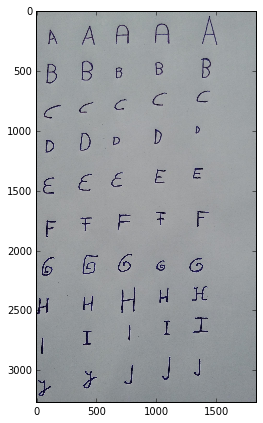

In [23]:
image_data = (ndimage.imread(dictionary_processing_files + copy_image_file))
figure_size= plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = {7.0,10.0}
plt.imshow(image_data, cmap=None)
plt.show()

In [24]:
#draw green rectangle (top_left_0 , filename , bottom_right_1 , bottom_right_0 , top_left_1)
for json_dictonary in green_rectange_data:
    filename = json_dictonary['filename']
    top_left_0 = json_dictonary['top_left_0']
    top_left_1 = json_dictonary['top_left_1']
    bottom_right_0 = json_dictonary['bottom_right_0']
    bottom_right_1 = json_dictonary['bottom_right_1']
    prediction_diget_top_1 = combined_images_with_predicted_results[filename][1]
    prediction_diget_top_1_reliability = combined_images_with_predicted_results[filename][0]
    
    cv2.rectangle(image_data,tuple((top_left_1, top_left_0)),tuple((bottom_right_1,bottom_right_0)),color=(0,255,0),thickness=5)

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image_data,str(chr(prediction_diget_top_1 + ord('A'))),(top_left_1,bottom_right_0 + 50),
               font,fontScale=1.4,color=(0,255,0),thickness=4)
    cv2.putText(image_data,format(prediction_diget_top_1_reliability*100,".1f")+"%",(top_left_1 + 70,bottom_right_0 + 50),
                font,fontScale=0.8,color=(0,255,0),thickness=2)
    
cv2.imwrite(dictionary_processing_files+final_result, image_data)

True

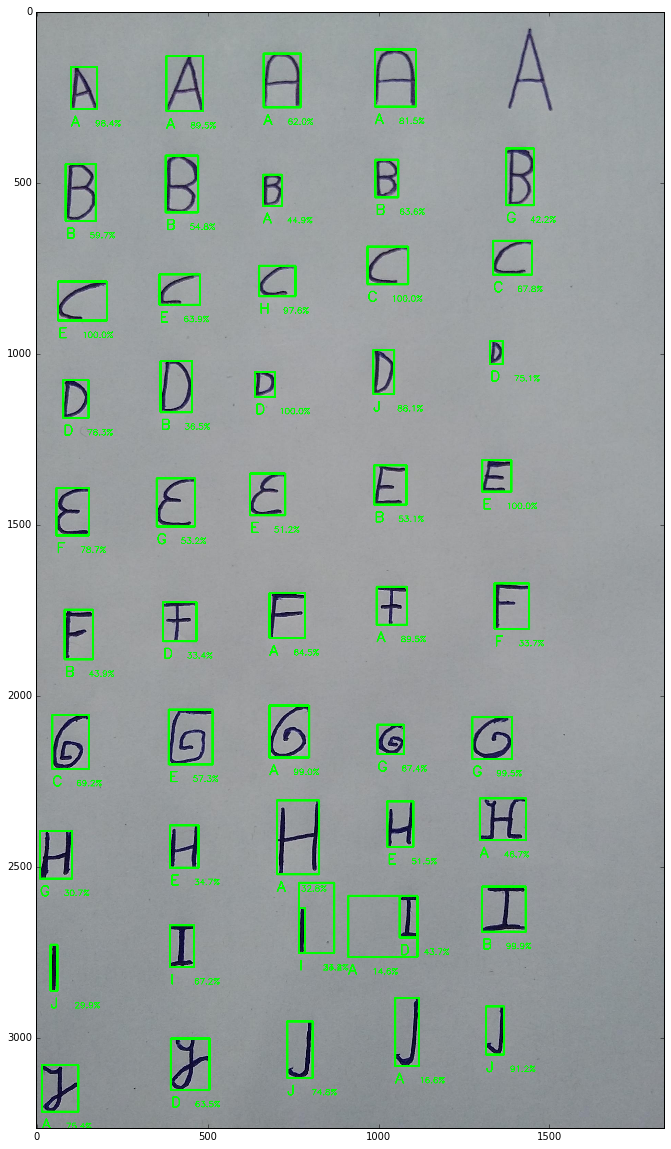

In [25]:
figure_size= plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = {20.0,24.0}
plt.imshow(image_data, cmap=None)
plt.show()

#### Side note


There are quite many pictures which are not showing letters A to J in the training data

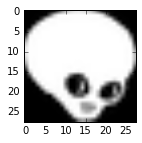

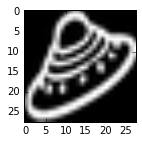

In [26]:
plotSingleImage(basket + "/notMNIST_large/G/" + "SXNpc0RpbmdzLnR0Zg==.png")
plotSingleImage(basket + "/notMNIST_large/B/" + "SXNpc0RpbmdzLnR0Zg==.png")

The images which represent letters are computer generated and do not represent typical handwriting

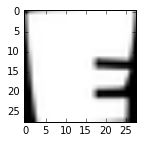

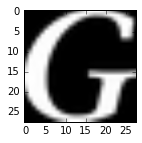

In [27]:
plotSingleImage(basket + "/notMNIST_large/E/" + "Rm9vLnR0Zg==.png")
plotSingleImage(basket + "/notMNIST_large/G/" + "T3JjaGlkIFNTaSBTZW1pIEJvbGQgSXRhbGljLnR0Zg==.png")